## Imports

In [146]:
import os
from datetime import datetime

In [60]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from transformers import BertTokenizer, TFBertModel
import re
import matplotlib.pyplot as plt 
import seaborn as sns

In [42]:
#VARIABLES

SAMPLE_MODE = False

SUBMISSION_MODE = False

MODEL_PATH = 'model1'

## Load data and model

In [43]:
## LOAD DATA

if SAMPLE_MODE:
    n_rows=15000
else:
    n_rows=None

if not SUBMISSION_MODE :
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        %cd /content/drive/MyDrive/feedback-prize
        df = pd.read_csv('train_filled.csv',n_rows=n_rows,index_col=0)
    except:
        df = pd.read_csv('../raw_data/train_filled.csv',nrows=n_rows,index_col=0)
    display(df.head())
else : 
    print('WIP')

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
59951,0000D23A521A,1.617735e+12,0.0,170.0,"Some people belive that the so called ""face"" o...",Position,Position 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
59952,0000D23A521A,1.617735e+12,170.0,357.0,"It was not created by aliens, and there is no ...",Evidence,Evidence 1,34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...
59953,0000D23A521A,1.617735e+12,358.0,438.0,"A mesa is a naturally occuring rock formation,...",Evidence,Evidence 2,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
59954,0000D23A521A,1.617735e+12,438.0,626.0,"This ""face"" on mars only looks like a face bec...",Claim,Claim 1,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...
59955,0000D23A521A,1.617735e+12,627.0,722.0,Many conspiracy theorists believe that NASA is...,Counterclaim,Counterclaim 1,117 118 119 120 121 122 123 124 125 126 127 12...


In [10]:
## LOAD MODEL 

try: 
    model = tf.keras.models.load_model(MODEL_PATH)
except:
    print("Run this notebook with COLAB")

Run this notebook with COLAB


## Preprocess data

In [7]:
def get_essay_df(path):
    
    with open(path,'r') as file : 
        text = file.read()
        id_ = path.split('/')[-1].split('.')[0]
        X = pd.DataFrame({'id':id_,'text':text},index=[0])
        
    X['discourse'] = X['text'].apply(lambda text : text.split('.'))
    
    X = X.explode('discourse').drop('text',axis=1)
    
    X['discourse'] = X['discourse'].apply(lambda text : re.sub('^[\n]+','',text))
    X['discourse'] = X['discourse'].apply(lambda text : re.sub('[\n]+$','',text))
    
    X.reset_index(drop=True, inplace=True)
    
    X['discourse_len'] = X['discourse'].apply(lambda text :len(text.split()))
    
    X['predictionstring_start'] = X.discourse_len.cumsum().shift(+1).fillna(0).astype(int)
    X['predictionstring_end'] = X.discourse_len.cumsum()-1
        
    f = np.vectorize(lambda a,b : ' '.join(list(map(str,range(a,b+1)))),otypes=[str])
    X['predictionstring'] = f(X['predictionstring_start'],X['predictionstring_end'])
    
    X.drop(['discourse_len','predictionstring_start','predictionstring_end'],axis=1,inplace=True)

    
    return X

In [10]:
path = '../raw_data/test/'
X = pd.DataFrame()
for file in os.listdir(path):
    X = X.append(get_essay_df(path+file))

,id,discourse,predictionstring
0,DF920E0A7337,Have you ever asked more than one person for h...,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,DF920E0A7337,"Interviews are seen on the news, in professio...",29 30 31 32 33 34 35 36 37 38 39 40 41 42
2,DF920E0A7337,There are a lot of people that can help you b...,43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
3,DF920E0A7337,They can all open you up to new ideas,59 60 61 62 63 64 65 66 67
4,DF920E0A7337,I think talking to more than one person on an...,68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 8...
...,...,...,...
25,D72CB1C11673,Making decisions can cause stress on a person,378 379 380 381 382 383 384 385
26,D72CB1C11673,Relating to someones advice may higher your s...,386 387 388 389 390 391 392 393 394 395 396 39...
27,D72CB1C11673,Ask others for advice when making a difficult...,401 402 403 404 405 406 407 408 409
28,D72CB1C11673,When you seek others opinion more opportuniti...,410 411 412 413 414 415 416 417 418 419 420


## Tokenizer

In [5]:
#initiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [14]:
X_tok = tokenizer(list(X['discourse']),max_length=256,padding = 'max_length',truncation=True,return_token_type_ids=False,return_tensors='tf')

2022-01-27 20:27:33.234296: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
X_tok

{'input_ids': <tf.Tensor: shape=(190, 256), dtype=int32, numpy=
array([[ 101, 2031, 2017, ...,    0,    0,    0],
       [ 101, 7636, 2024, ...,    0,    0,    0],
       [ 101, 2045, 2024, ...,    0,    0,    0],
       ...,
       [ 101, 3198, 2500, ...,    0,    0,    0],
       [ 101, 2043, 2017, ...,    0,    0,    0],
       [ 101,  102,    0, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(190, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=int32)>}

In [26]:
from transformers import TFBertModel

DISCOURSE_LEN = 256

pretrained_bert = TFBertModel.from_pretrained("bert-base-uncased")

def create_sentence_based():
    input_ids = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    x = pretrained_bert({'input_ids':input_ids,
                        'attention_mask':attention_mask})[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(.2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(8, activation='softmax',name='outputs')(x)

    pretrained_bert.trainable=False

    model = tf.keras.Model(inputs={'input_ids':input_ids,
                                'attention_mask':attention_mask},
                        outputs=output)

    return model

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [30]:
## Instantiate a model and load the weights of trained model
model = create_sentence_based()
model.load_weights('../models/weights_sentences_based_model/weights_baseline')

In [33]:
## Run the model and store its prediction into y
y = model(X_tok)

In [34]:
## map the label of the prediction

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([0.05456246, 0.09897028, 0.05793805, 0.02511611, 0.01224761,
       0.05072896, 0.6979462 , 0.00249039], dtype=float32)>

In [35]:
np.argmax(y[0])

6

In [68]:
# Labels and reversed labels 

#commented to avoid errors in the future and hardcoded 
#labels={l:i for i,l in enumerate(df.discourse_type.unique())}
labels={0: 'Position',
 1: 'Evidence',
 2: 'Claim',
 3: 'Counterclaim',
 4: 'Rebuttal',
 5: 'Concluding Statement',
 6: 'Lead',
 7: 'None'}


reversed_labels = {v:k for k,v in labels.items()}

y_labeled = pd.Series(np.argmax(y,axis=1)).map(labels)


<AxesSubplot:ylabel='count'>

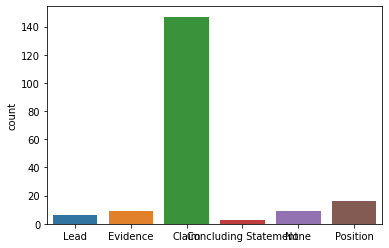

In [69]:
sns.countplot(x=y_labeled)

In [126]:
## create csv_file for kaggle submission 

X.reset_index(drop=True, inplace=True)

submission = pd.concat([X,y_labeled],axis=1)
submission.rename(columns={0:'class'},inplace=True)
submission.drop('discourse',axis=1,inplace=True)

sub_clean = submission.index[((submission['predictionstring']=='\xa0')|(submission['predictionstring']==''))]
submission.drop(sub_clean,inplace=True)

submission.reset_index(drop=True,inplace=True)

submission=submission[['id','class','predictionstring']]
submission

,id,class,predictionstring
0,DF920E0A7337,Lead,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
1,DF920E0A7337,Evidence,29 30 31 32 33 34 35 36 37 38 39 40 41 42
2,DF920E0A7337,Claim,43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
3,DF920E0A7337,Claim,59 60 61 62 63 64 65 66 67
4,DF920E0A7337,Concluding Statement,68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 8...
...,...,...,...
181,D72CB1C11673,Claim,362 363 364 365 366 367 368 369 370 371 372 37...
182,D72CB1C11673,Claim,378 379 380 381 382 383 384 385
183,D72CB1C11673,Claim,386 387 388 389 390 391 392 393 394 395 396 39...
184,D72CB1C11673,Claim,401 402 403 404 405 406 407 408 409


In [147]:
#export to csv

today = datetime.today()
timestamp = datetime.strftime(today,"%d_%m_%H:%M")

submission.to_csv(f'../raw_data/submission_{timestamp}.csv')